In [144]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np 
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, balanced_accuracy_score, f1_score, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import precision_recall_curve, classification_report, precision_score, recall_score, confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.utils import resample 

import shap

In [145]:
def compute_metrics(y_true, y_pred):
            print("F1 Score: ", round(( f1_score(y_test, y_pred)* 100),2), "%")
            print("Recall Score: ", round(( recall_score(y_test, y_pred)* 100),2), "%")
            print("Presicion Score: ", round(( precision_score(y_test, y_pred)* 100),2), "%")

In [146]:
def best_threshold(y_test, y_proba):
    
    best_f1 = 0

    x = []
    f1score = []
    recall = []
    Presicion_Score = []

    for i in np.linspace(0.04, 0.95, num = 50):

        y_pred = [0 if x < i else 1 for x in y_proba]

        x.append(i)
        
        f1score.append(f1_score(y_test, y_pred))

        recall.append(recall_score(y_test, y_pred))

        Presicion_Score.append(precision_score(y_test, y_pred, zero_division = 0))


        if f1_score(y_test, y_pred) > best_f1:
            best_f1 = f1_score(y_test, y_pred)
            best_i = i
    print("Optimal Threshold->", round(best_i,4), "f1->", round(best_f1,2))
    

    y_pred = [0 if x < best_i else 1 for x in y_proba]
    
    print(compute_metrics(y_test, y_pred))
    
    print("ROC_AUC_Score: ", round(( roc_auc_score(y_test, y_proba)* 100),2), "%")
    
    plt.figure(figsize = (16, 8))
    plt.xlabel("Binarization threshold");
    plt.ylabel('Metrics Value');
    plt.plot(x, f1score)
    plt.plot(x, recall)
    plt.plot(x, Presicion_Score)
    plt.legend(["F1_score", "Recall_score", "Presicion_score"])
    plt.show()


# train_test_split

In [147]:
data = pd.read_csv("Mdata.csv", delimiter=',')
# выделеям таргет
target = data.loan_default
# Удаляем таргет из датасета
data.drop(labels="loan_default", axis=1, inplace=True)

# LogisticRegression

In [148]:
X_train, X_test, y_train, y_test=train_test_split(data,
                                                  target,
                                                  stratify=target,
                                                  test_size=0.2,
                                                  random_state=13)

In [149]:
scaler = StandardScaler()
X_train[data.columns] = scaler.fit_transform(X_train[data.columns])
X_test = scaler.transform(X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Optimal Threshold-> 0.5043 f1-> 0.38
F1 Score:  38.15 %
Recall Score:  64.59 %
Presicion Score:  27.07 %
None
ROC_AUC_Score:  68.37 %


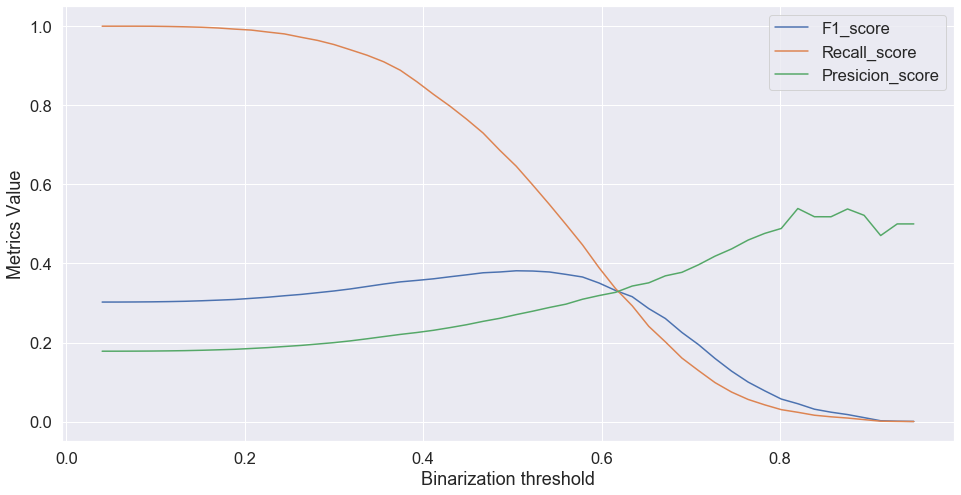

None


In [151]:
lr = LogisticRegression(random_state=13, penalty = "l2", class_weight = "balanced", max_iter=1000) 
lr.fit(X_train, y_train)
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]
print(best_threshold(y_test,y_pred_proba_lr))

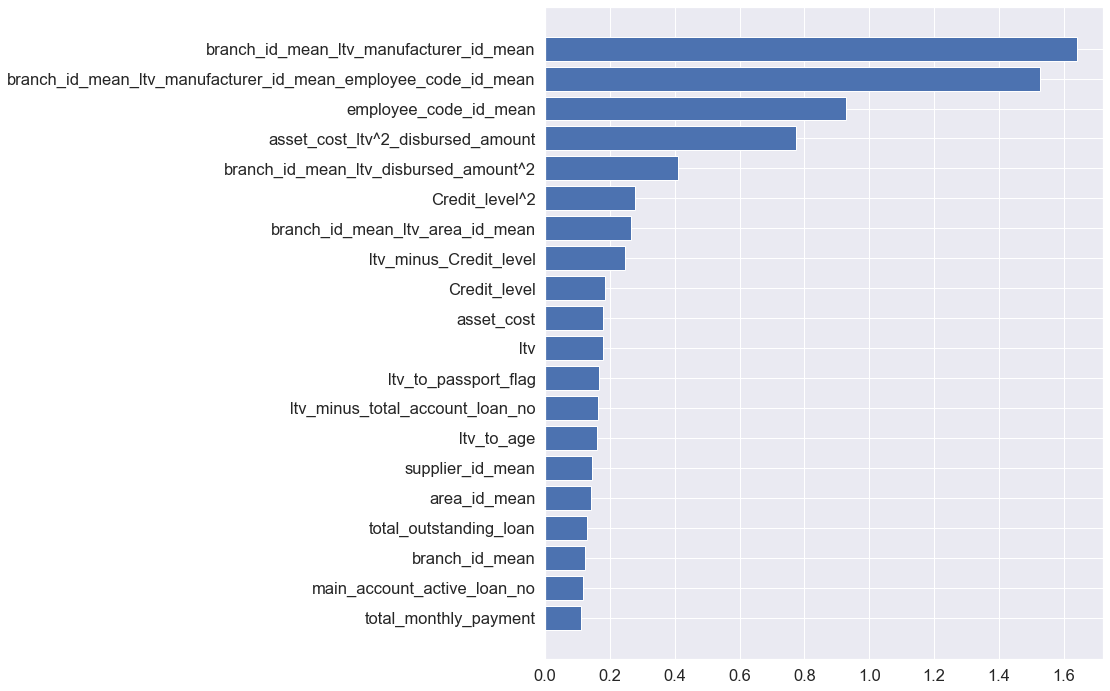

In [152]:
important_features = sorted(list(zip(data.columns, lr.coef_[0])),key = lambda x: np.abs(x[1]),reverse=True)[:20]

important_features = sorted(important_features, key = lambda x: np.abs(x[1]))
# importamt_features
plt.figure(figsize = (10, 12))
plt.barh([x[0] for x in important_features], [np.abs(x[1]) for x in important_features],)
plt.show()

In [153]:
y_pred = [0 if x < 0.5043 else 1 for x in lr.predict_proba(X_test)[:,1]]

print(compute_metrics(y_test, y_pred))

F1 Score:  38.15 %
Recall Score:  64.57 %
Presicion Score:  27.07 %
None


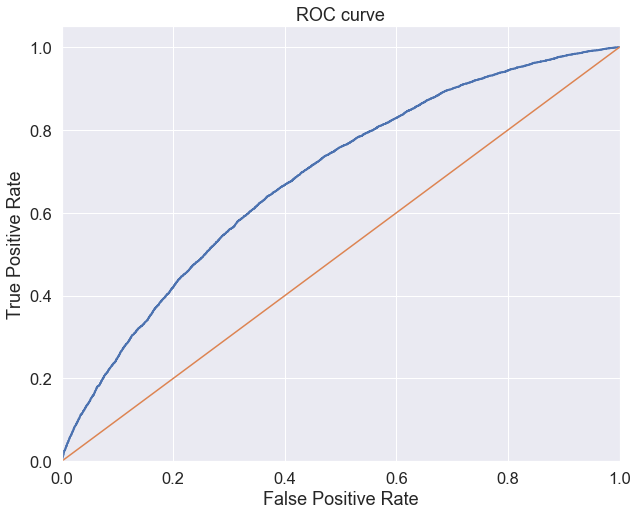

In [154]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, (lr.predict_proba(X_test)[:, 1]), pos_label=1)

lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [155]:
report = classification_report(y_test, y_pred, target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.89      0.62      0.73     32393
     Churned       0.27      0.65      0.38      7020

    accuracy                           0.63     39413
   macro avg       0.58      0.63      0.56     39413
weighted avg       0.78      0.63      0.67     39413



In [120]:
# Проверка гиперпараметра С
# rocauc_of_model = []
# F1_Score = []
# Recall_Score = []
# Presicion_Score = []
# x = []
# for i in np.linspace(0.01,1,num=15):
#     lr = LogisticRegression(random_state=13, C = i, penalty = "l2", class_weight = "balanced",max_iter=1000)
#     lr.fit(X_train, y_train)
#     y_pred = lr.predict(X_test)
#     y_proba = lr.predict_proba(X_test)[:,1]
#     x.append(round(i,3))
#     rocauc_of_model.append(roc_auc_score(y_test, y_proba))
#     F1_Score.append(f1_score(y_test, y_pred))
#     Recall_Score.append(recall_score(y_test, y_pred))
#     Presicion_Score.append(precision_score(y_test, y_pred))

# plt.figure(figsize = (16, 8))

# plt.plot(x, rocauc_of_model)
# plt.plot(x, F1_Score)
# plt.plot(x, Recall_Score)
# plt.plot(x, Presicion_Score)

# plt.legend(["RocAuc_of_model", "F1_Score","Recall_Score", "Presicion_Score"])
# plt.show()

# Нелинейные модели

In [156]:
X_train, X_test, y_train, y_test=train_test_split(
    data,
    target,
    stratify=target,
    test_size=0.2,
    random_state=13)

In [157]:
scaler = StandardScaler()
X_train[data.columns] = scaler.fit_transform(X_train[data.columns])
X_test = scaler.transform(X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# RandomForestClassifier

In [158]:
rfc = RandomForestClassifier(class_weight = "balanced",
                             n_estimators=100,
                             min_samples_leaf = 25, 
                             max_depth = 20, 
                             n_jobs = -1
                            ).fit(X_train, y_train)


y_proba_rfc = rfc.predict_proba(X_test)[:,1]

Optimal Threshold-> 0.4671 f1-> 0.38
F1 Score:  38.1 %
Recall Score:  57.21 %
Presicion Score:  28.56 %
None
ROC_AUC_Score:  68.38 %


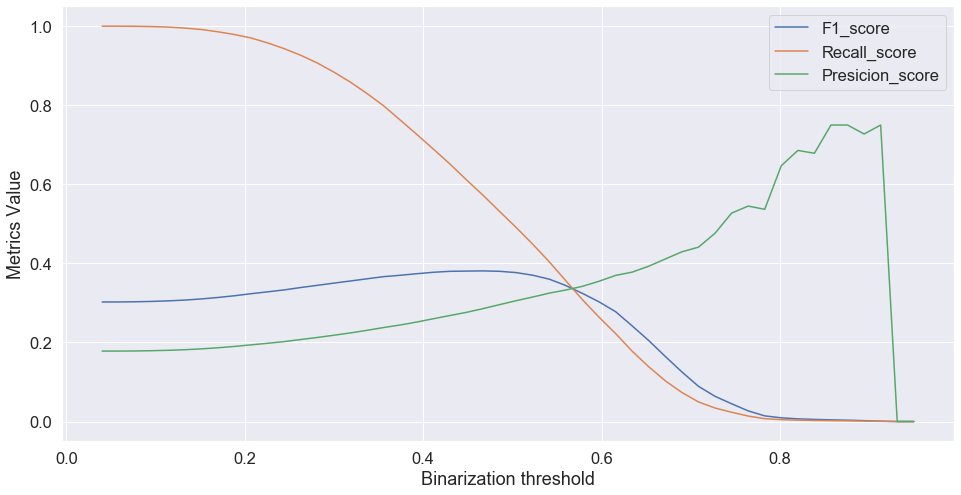

In [159]:
best_threshold(y_test, y_proba_rfc)

In [160]:
y_pred = [0 if x < 0.4671 else 1 for x in y_proba_rfc]
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([25352, 14061], dtype=int64))

In [161]:
compute_metrics(y_test, y_pred)

F1 Score:  38.1 %
Recall Score:  57.21 %
Presicion Score:  28.56 %


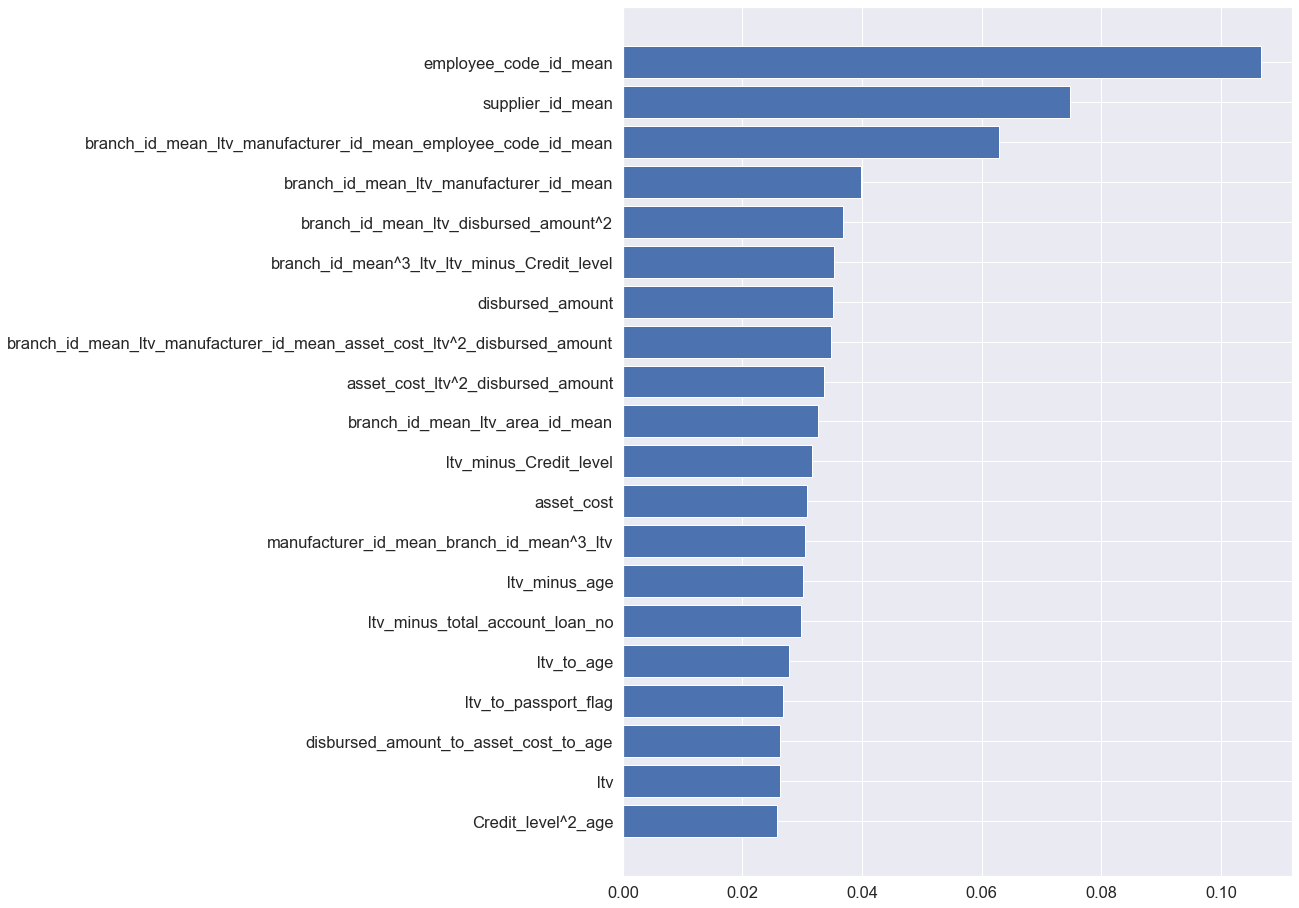

In [162]:
important_features_rfc = sorted(list(zip(data.columns, rfc.feature_importances_)),key = lambda x: np.abs(x[1]),reverse=True)[:20]
important_features_rfc = sorted(important_features_rfc, key = lambda x: np.abs(x[1]))
plt.figure(figsize = (12, 16))
plt.barh([x[0] for x in important_features_rfc], [x[1] for x in important_features_rfc])
plt.show()


# xgboost

In [163]:
X_train, X_test, y_train, y_test=train_test_split(
    data,
    target,
    stratify=target,
    test_size=0.2,
    random_state=13)

In [164]:
scaler = StandardScaler()
X_train[data.columns] = scaler.fit_transform(X_train[data.columns])
X_test = scaler.transform(X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [165]:
XGBmodel = xgboost.XGBRegressor(max_depth = 4, n_estimators = 50, scale_pos_weight=4).fit(X_train, y_train)
y_proba_xgb = XGBmodel.predict(X_test)

Optimal Threshold-> 0.4671 f1-> 0.38
F1 Score:  38.48 %
Recall Score:  65.63 %
Presicion Score:  27.22 %
None
ROC_AUC_Score:  68.78 %


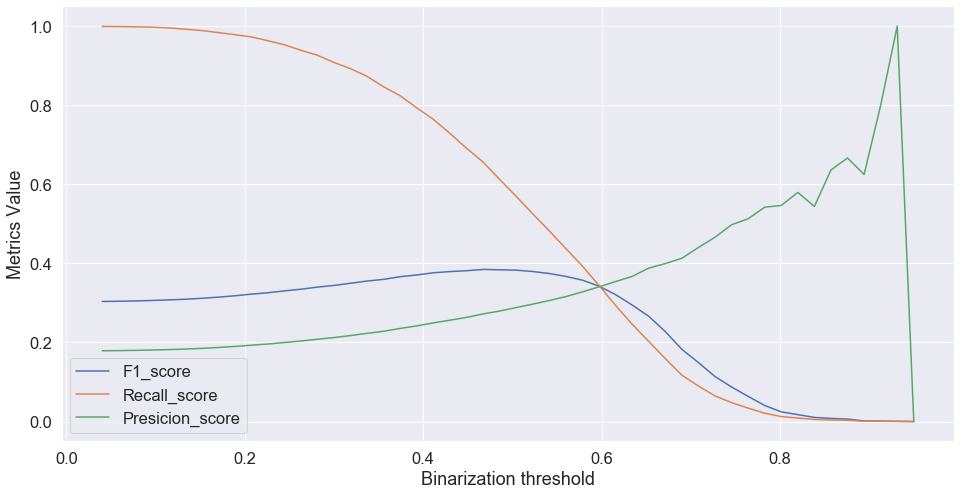

In [166]:
best_threshold(y_test, y_proba_xgb)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


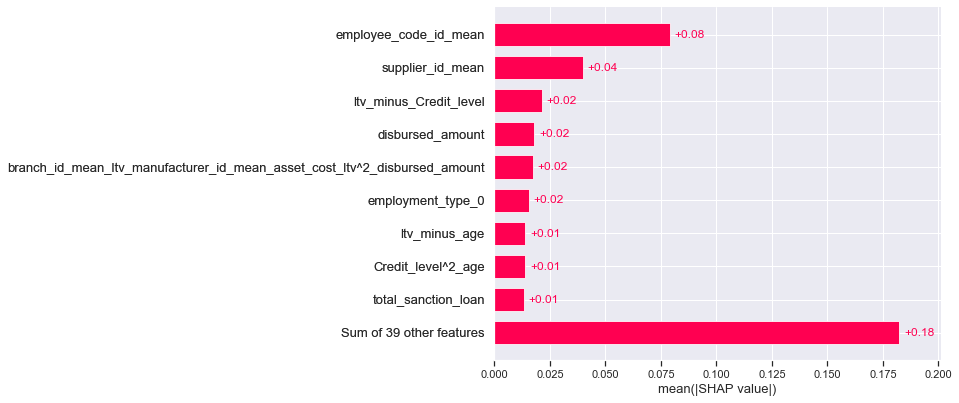

In [167]:
explainer = shap.Explainer(XGBmodel)
shap_values = explainer(X_train)

shap.plots.bar(shap_values)

In [168]:
y_pred = [0 if x < 0.4671 else 1 for x in y_proba_xgb]
print(np.unique(y_pred, return_counts=True))
print(compute_metrics(y_test, y_pred))

(array([0, 1]), array([22486, 16927], dtype=int64))
F1 Score:  38.48 %
Recall Score:  65.63 %
Presicion Score:  27.22 %
None


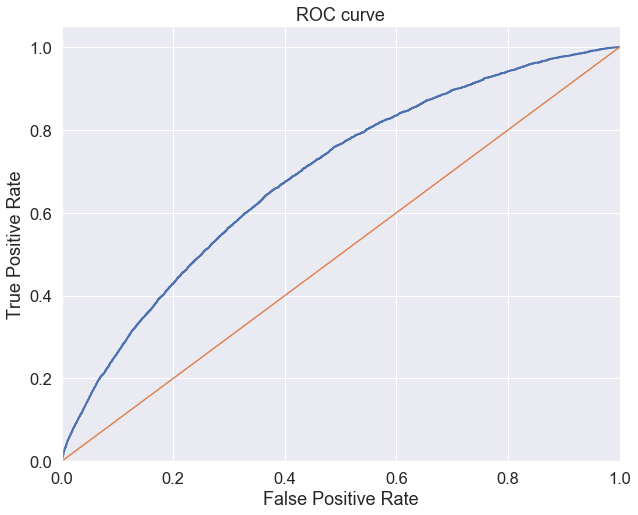

ROC_AUC_Score:  68.78 %


In [169]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb, pos_label=1)

lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

print("ROC_AUC_Score: ", round(( roc_auc_score(y_test, y_proba_xgb)* 100),2), "%")

# LightGBM

In [182]:
X_train, X_test, y_train, y_test=train_test_split(
    data,
    target,
    stratify=target,
    test_size=0.2,
    random_state=13)

In [183]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'auc',
    "learning_rate" : 0.05,
    'num_leaves': 35, 
    "lambda_l1": 0.6,
    "lambda_l2": 15,
    "max_depth": 15,
    "cat_smooth": 1,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.95,
    'bagging_freq': 6,
    'verbose': 1,
    }


# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=100)



y_pred_gbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7663
[LightGBM] [Info] Number of data points in the train set: 157652, number of used features: 48
[LightGBM] [Info] Start training from score 0.178120
[1]	valid_0's auc: 0.653243
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.658125
[3]	valid_0's auc: 0.669634
[4]	valid_0's auc: 0.673016
[5]	valid_0's auc: 0.673408
[6]	valid_0's auc: 0.674712
[7]	valid_0's auc: 0.67552
[8]	valid_0's auc: 0.677313
[9]	valid_0's auc: 0.677824
[10]	valid_0's auc: 0.678547
[11]	valid_0's auc: 0.678869
[12]	valid_0's auc: 0.679254
[13]	valid_0's auc: 0.679551
[14]	valid_0's auc: 0.679794
[15]	valid_0's auc: 0.680141
[16]	valid_0's auc: 0.680354
[17]	valid_0's auc: 0.680698
[18]	valid_0's auc: 0.680817
[19]	valid_0's auc: 0.68127
[20]	valid_0's auc: 0.681623
[21]	valid_0's auc: 0.6

[292]	valid_0's auc: 0.693194
[293]	valid_0's auc: 0.693179
[294]	valid_0's auc: 0.693167
[295]	valid_0's auc: 0.693218
[296]	valid_0's auc: 0.693232
[297]	valid_0's auc: 0.69323
[298]	valid_0's auc: 0.693245
[299]	valid_0's auc: 0.693235
[300]	valid_0's auc: 0.693202
[301]	valid_0's auc: 0.69316
[302]	valid_0's auc: 0.693135
[303]	valid_0's auc: 0.693122
[304]	valid_0's auc: 0.693129
[305]	valid_0's auc: 0.693126
[306]	valid_0's auc: 0.693129
[307]	valid_0's auc: 0.69314
[308]	valid_0's auc: 0.693123
[309]	valid_0's auc: 0.693145
[310]	valid_0's auc: 0.693165
[311]	valid_0's auc: 0.693144
[312]	valid_0's auc: 0.693155
[313]	valid_0's auc: 0.693118
[314]	valid_0's auc: 0.69309
[315]	valid_0's auc: 0.693108
[316]	valid_0's auc: 0.693071
[317]	valid_0's auc: 0.693066
[318]	valid_0's auc: 0.693068
[319]	valid_0's auc: 0.693062
[320]	valid_0's auc: 0.693083
[321]	valid_0's auc: 0.693086
[322]	valid_0's auc: 0.693075
[323]	valid_0's auc: 0.69307
[324]	valid_0's auc: 0.693052
[325]	valid_0's

Optimal Threshold-> 0.2071 f1-> 0.39
F1 Score:  38.88 %
Recall Score:  56.92 %
Presicion Score:  29.52 %
None
ROC_AUC_Score:  69.34 %


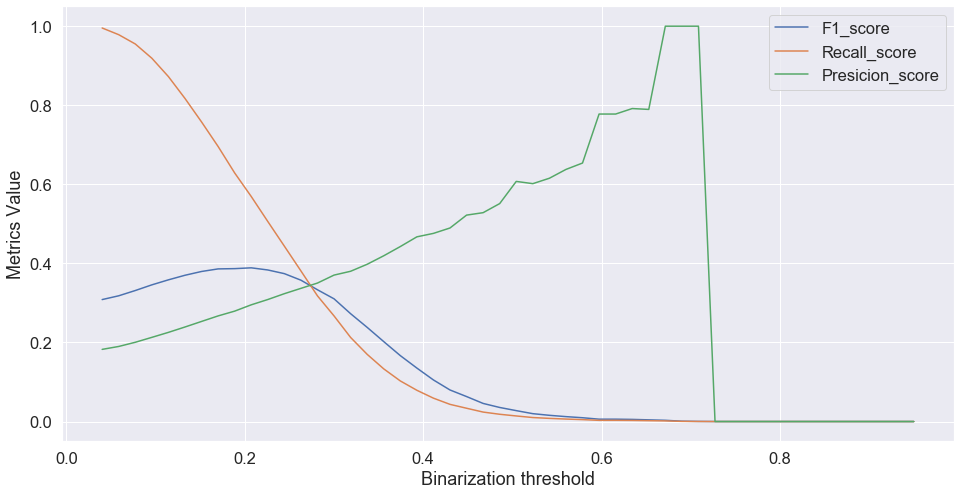

In [173]:
best_threshold(y_test, y_pred_gbm)

In [185]:
y_pred = [0 if x < 0.2071 else 1 for x in y_pred_gbm]
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([25874, 13539], dtype=int64))

In [186]:
compute_metrics(y_test, y_pred)

F1 Score:  38.89 %
Recall Score:  56.95 %
Presicion Score:  29.53 %


auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


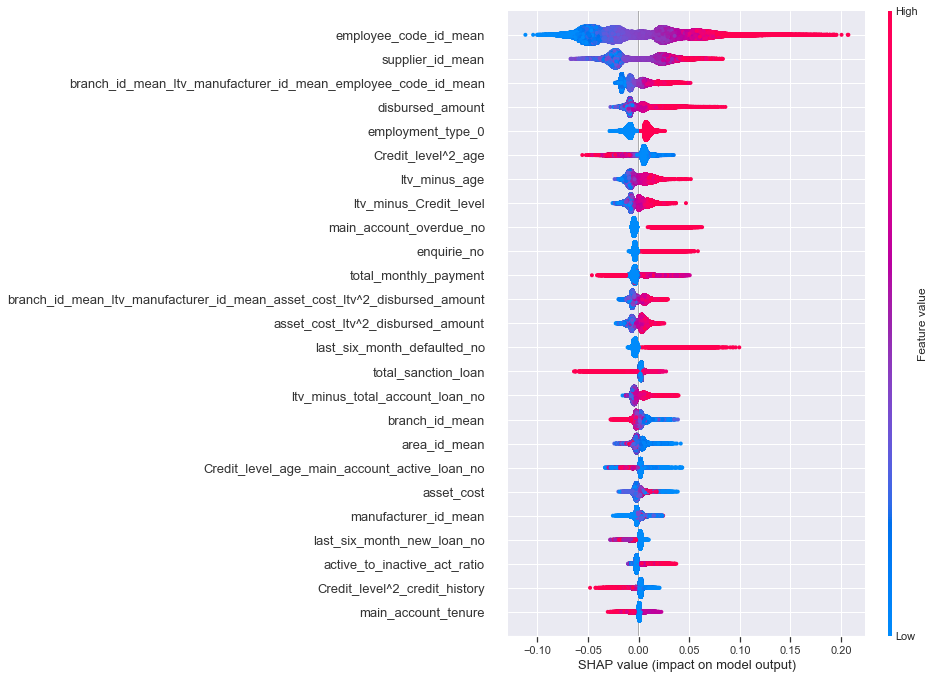

In [176]:
shap_test = shap.TreeExplainer(gbm).shap_values(X_train)
shap.summary_plot(shap_test, X_train,
                      max_display=25, plot_size=None)

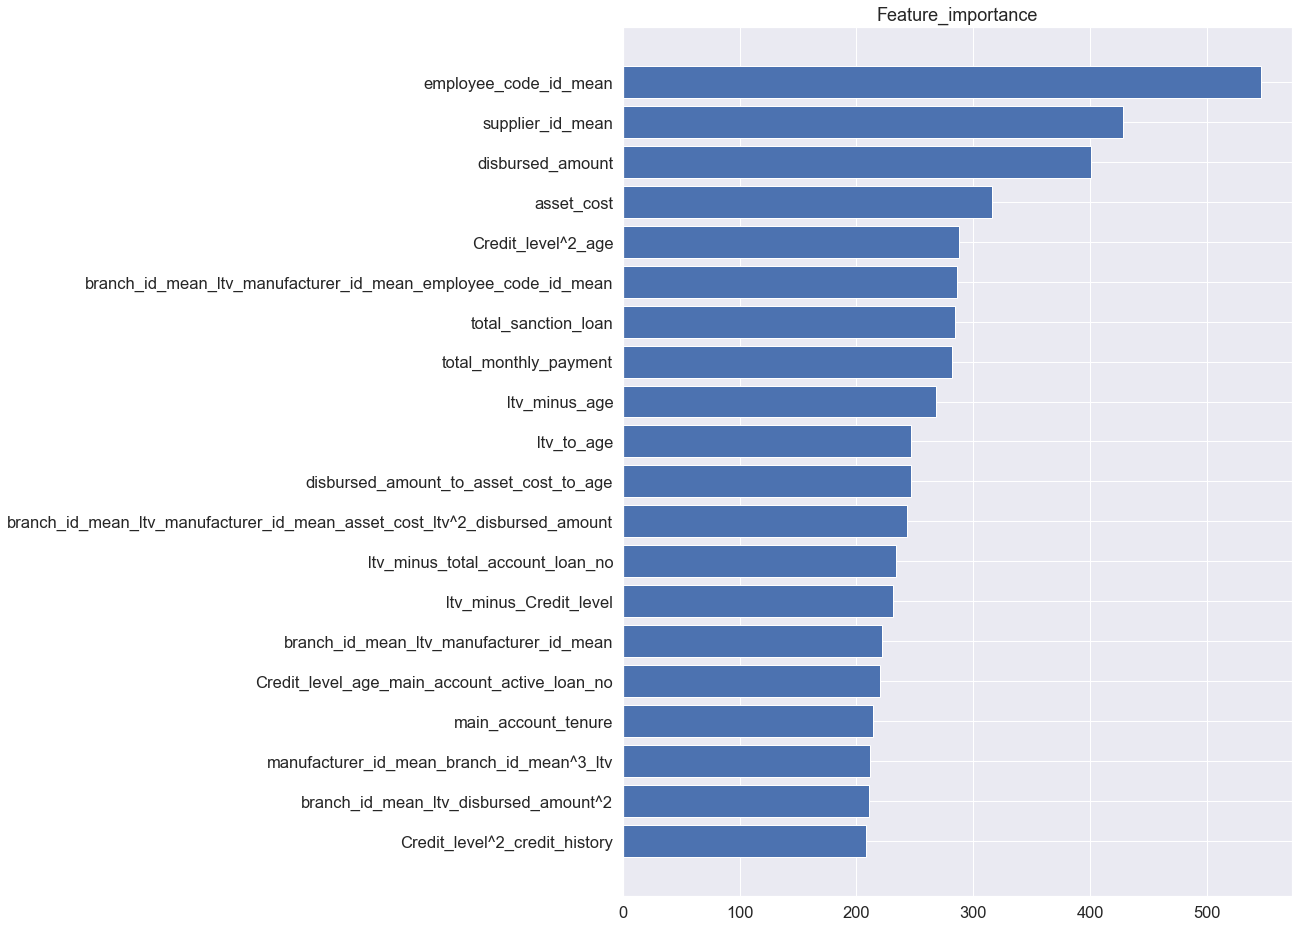

In [141]:
important_features_rfc = sorted(list(zip(data.columns, gbm.feature_importance())),key = lambda x: np.abs(x[1]),reverse=True)[:20]
important_features_rfc = sorted(important_features_rfc, key = lambda x: np.abs(x[1]))
plt.figure(figsize = (12, 16))
plt.barh([x[0] for x in important_features_rfc], [x[1] for x in important_features_rfc])
plt.title('Feature_importance')
plt.show()


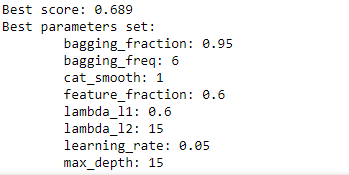